<a href="https://colab.research.google.com/github/yeonghun00/market-risk/blob/main/ARIMA%20Model%20and%20Monte%20Carlo%20Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance statsmodels matplotlib numpy

### **ARIMA Model for Time Series Forecasting**


In [2]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from scipy.stats import norm

# Fetching historical data for S&P 500 from Yahoo Finance
sp500 = yf.download('^GSPC', start='2010-01-01', end=datetime.today().strftime('%Y-%m-%d'))

# Check the first few rows
sp500.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


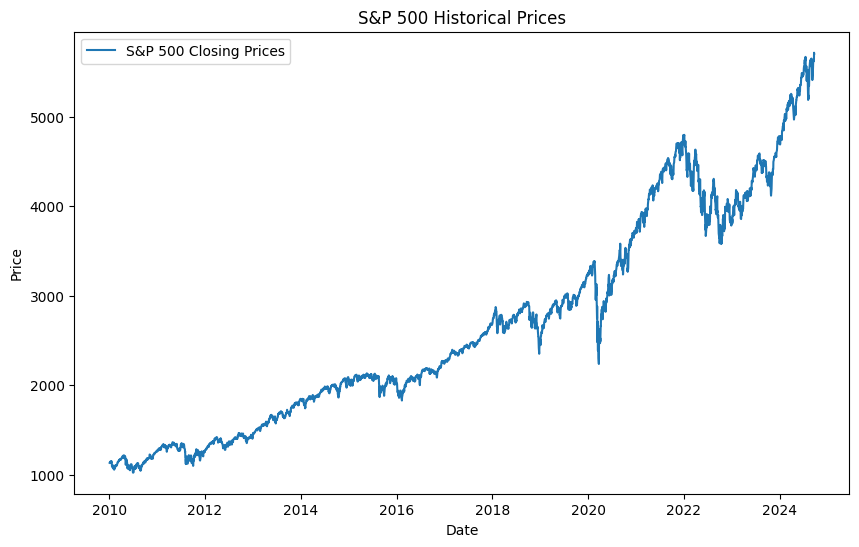

In [3]:
# Plot the closing price
plt.figure(figsize=(10, 6))
plt.plot(sp500['Close'], label='S&P 500 Closing Prices')
plt.title('S&P 500 Historical Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#### Differencing the Data

The differenced series is given by:

$$ \Delta P_t = P_t - P_{t-1} $$

where $\Delta P_t$ is the differenced time series at time $t$. This helps in removing trends and making the series stationary.


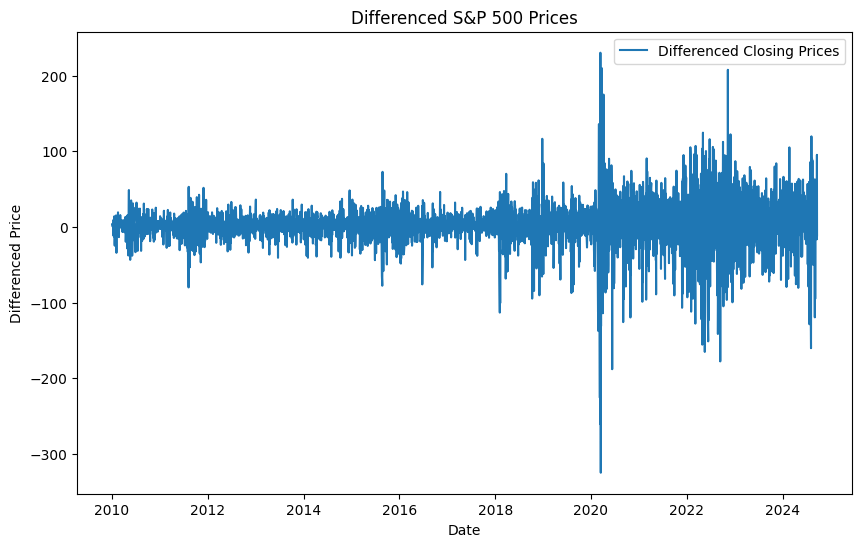

In [4]:
sp500['Close_diff'] = sp500['Close'].diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(sp500['Close_diff'], label='Differenced Closing Prices')
plt.title('Differenced S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()


#### Fitting ARIMA

We use ARIMA(1,1,1) as a starting point for fitting the model. The fitted model provides us with the coefficients for the AR, I, and MA terms, which can be used for forecasting future prices.

The model estimates parameters for:

- $\phi_1$: AR term
- $\theta_1$: MA term


In [5]:
# Fit the ARIMA model (p, d, q)
# Here, we'll start with a simple ARIMA(1,1,1) model

model = ARIMA(sp500['Close'], order=(1,1,1))
arima_result = model.fit()

# Display model summary
print(arima_result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3704
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17979.685
Date:                Sat, 21 Sep 2024   AIC                          35965.369
Time:                        08:56:36   BIC                          35984.020
Sample:                             0   HQIC                         35972.006
                               - 3704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3897      0.066     -5.949      0.000      -0.518      -0.261
ma.L1          0.3067      0.068      4.493      0.000       0.173       0.440
sigma2       966.4267      9.535    101.354      0.0

#### Forecasting Future Values

To forecast future values, we use the fitted ARIMA model. For the next $n$ periods (e.g., 30 days), the forecast is:

$$ \hat{P}_{t+h} = c + \phi_1 \hat{P}_{t+h-1} + \dots + \phi_p \hat{P}_{t+h-p} + \theta_1 \epsilon_{t+h-1} + \dots + \theta_q \epsilon_{t+h-q} $$

Where:

- $h$: the forecast horizon (e.g., 1 day, 2 days, etc.)
- $\hat{P}_{t+h}$: forecasted value at time $t+h$

The confidence intervals are also plotted, which represent the uncertainty around the forecast.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


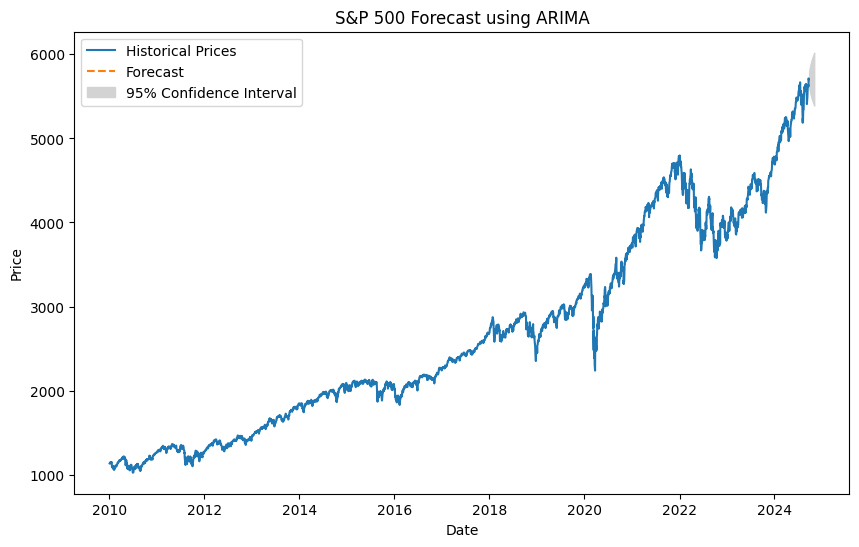

In [6]:
# Forecast future values
forecast_steps = 30  # Forecast for the next 30 days
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=sp500.index[-1], periods=forecast_steps+1, freq='B')[1:]

forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecast'])
forecast_conf_int = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(sp500['Close'], label='Historical Prices')
plt.plot(forecast_df, label='Forecast', linestyle='--')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='lightgrey', label='95% Confidence Interval')
plt.title('S&P 500 Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


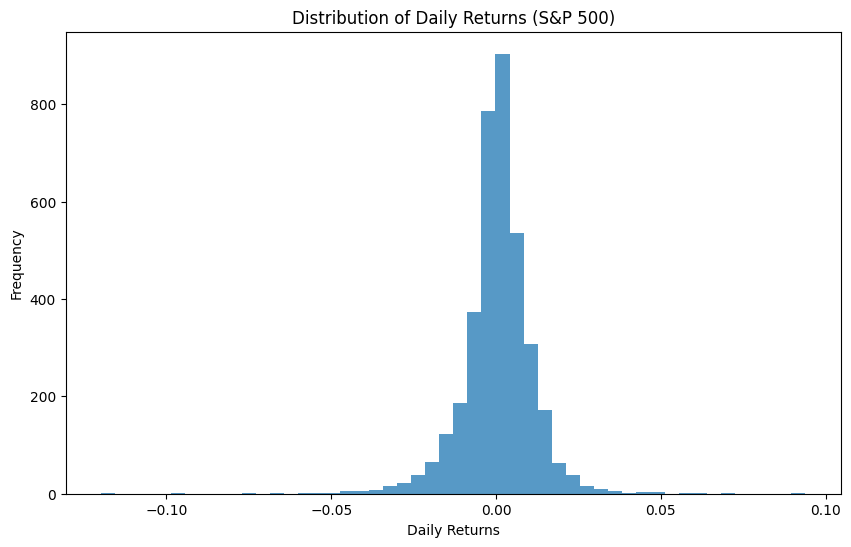

In [7]:
# Calculate daily returns
sp500['Returns'] = sp500['Close'].pct_change().dropna()

# Visualize daily returns
plt.figure(figsize=(10, 6))
plt.hist(sp500['Returns'], bins=50, alpha=0.75)
plt.title('Distribution of Daily Returns (S&P 500)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()


 ### **Monte Carlo Simulation for Price Prediction)**


The simulation assumes that returns follow a normal distribution. The future price of an asset can be modeled as:

$$ P_t = P_{t-1} \times (1 + r_t) $$

where:

- $P_t$: simulated price at time $t$
- $r_t$: random return drawn from a normal distribution $N(\mu, \sigma)$
- $\mu$: mean of historical returns
- $\sigma$: standard deviation of historical returns

We simulate multiple price paths, each representing a possible outcome for the S&P 500.


<ipython-input-8-3eb78e335e78>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = sp500['Close'][-1]


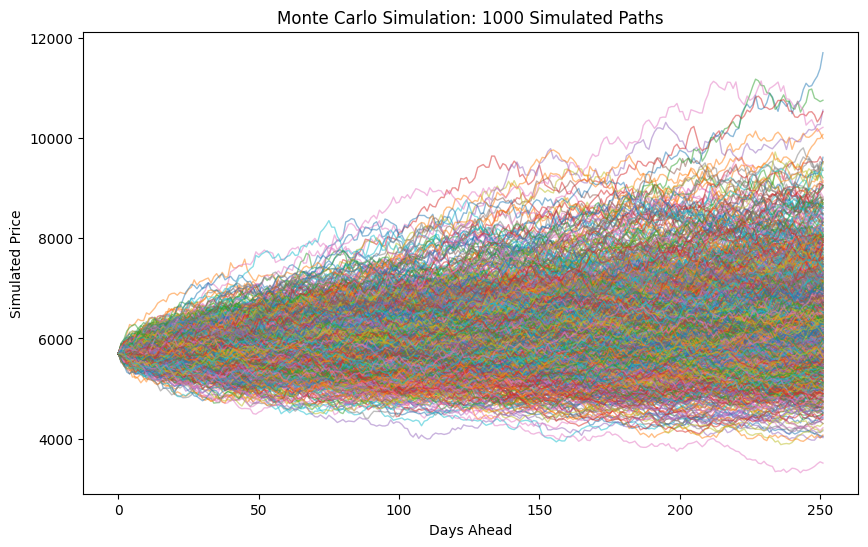

In [8]:
# Monte Carlo simulation parameters
num_simulations = 1000
num_days = 252  # Simulating one year ahead (252 trading days)
last_price = sp500['Close'][-1]

# Daily return mean and standard deviation
mean_return = sp500['Returns'].mean()
std_return = sp500['Returns'].std()

# Monte Carlo simulation for price projection
simulated_price_paths = np.zeros((num_days, num_simulations))
simulated_price_paths[0] = last_price

for t in range(1, num_days):
    random_shocks = np.random.normal(loc=mean_return, scale=std_return, size=num_simulations)
    simulated_price_paths[t] = simulated_price_paths[t-1] * (1 + random_shocks)

# Plotting Monte Carlo simulation
plt.figure(figsize=(10, 6))
plt.plot(simulated_price_paths, lw=1, alpha=0.5)
plt.title(f'Monte Carlo Simulation: {num_simulations} Simulated Paths')
plt.xlabel('Days Ahead')
plt.ylabel('Simulated Price')
plt.show()


#### Simulating Price Paths

For each simulation, a random return is drawn from the historical return distribution. The future price is calculated iteratively using:

$$ P_t = P_0 \times \prod_{i=1}^{t} (1 + r_i) $$

where:

- $P_0$: initial price (latest actual closing price)
- $r_i$: daily returns drawn from the normal distribution

By simulating hundreds or thousands of such price paths, we can model potential future price movements over a given time horizon (e.g., 252 trading days).


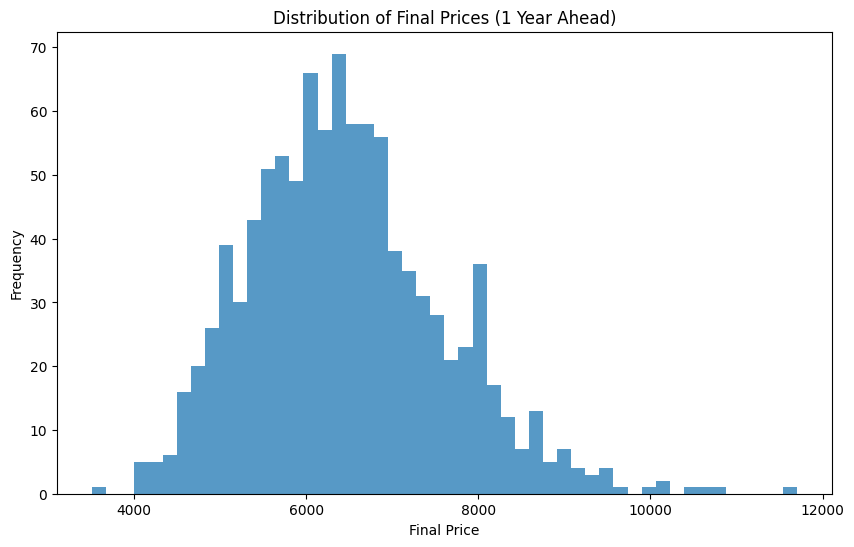

5th Percentile Price: 4793.594794970908
95th Percentile Price: 8446.421536037531


In [9]:
# Final simulated prices after one year
final_prices = simulated_price_paths[-1, :]

# Histogram of final prices
plt.figure(figsize=(10, 6))
plt.hist(final_prices, bins=50, alpha=0.75)
plt.title('Distribution of Final Prices (1 Year Ahead)')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()

# Calculating percentiles (VaR)
percentile_5 = np.percentile(final_prices, 5)
percentile_95 = np.percentile(final_prices, 95)

print(f"5th Percentile Price: {percentile_5}")
print(f"95th Percentile Price: {percentile_95}")
